In [ ]:
# default_exp simple_bayesian_inference

# simple_bayesian_inference

> API details.

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## I. Bayesian Inference in 3 Easy Steps

#### Step 1: Specify a probability model

In [ ]:
# Discrete Random Variables
from pymc3 import Poisson

x = Poisson.dist(mu=1)
samples = x.random(size=10000)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
samples.mean(), samples.std()

(0.9944, 1.0006840860131634)

(array([3.713e+03, 3.671e+03, 1.804e+03, 6.240e+02, 1.570e+02, 2.200e+01,
        8.000e+00, 1.000e+00]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

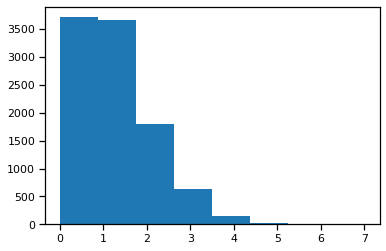

In [ ]:
plt.hist(samples, bins=len(set(samples)))

In [ ]:
# Continuous Random Variables
from pymc3 import Normal

y = Normal.dist(mu=-1, sd=4)
samples = y.random(size=10000)

In [ ]:
samples.mean(), samples.std()

(-0.9696848024533491, 3.9860246198576657)

(array([  20.,  143.,  766., 1903., 2841., 2520., 1366.,  377.,   58.,
           6.]),
 array([-15.34311678, -12.32728128,  -9.31144579,  -6.29561029,
         -3.27977479,  -0.26393929,   2.75189621,   5.7677317 ,
          8.7835672 ,  11.7994027 ,  14.8152382 ]),
 <a list of 10 Patch objects>)

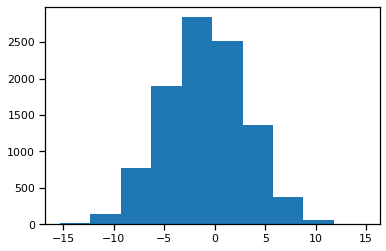

In [ ]:
plt.hist(samples)

#### Step 2: Calculate a posterior distribution

#### Step 3: Check your model

## II. Estimation for one group

In [ ]:
radon = pd.read_csv("data/radon.csv", index_col=0)
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


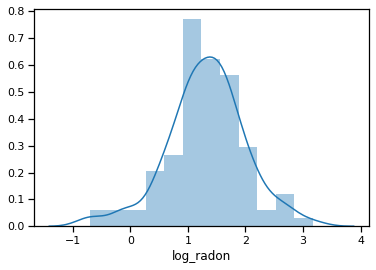

In [ ]:
# Select data for one county (HENNEPIN)
hen_radon = radon.query('county=="HENNEPIN"').log_radon
sns.distplot(hen_radon)

In [ ]:
# Prior model
from pymc3 import Model, Uniform

with Model() as radon_model:
    μ = Normal('μ', mu=0, sd=10)
    σ = Uniform('σ', 0, 10)    

In [ ]:
with radon_model:
    y = Normal('y', mu=μ, sd=σ, observed=hen_radon)

In [ ]:
from pymc3 import fit

with radon_model:
    samples = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 136.37


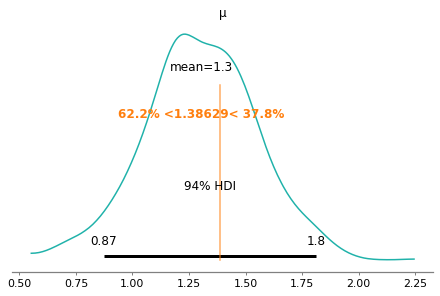

In [ ]:
from pymc3 import plot_posterior

plot_posterior(samples, var_names=['μ'], ref_val=np.log(4), color='LightSeaGreen');

In [ ]:
samples.__dict__

{'_straces': {0: <pymc3.backends.ndarray.NDArray at 0x7efdcac424d0>},
 '_report': <pymc3.backends.report.SamplerReport at 0x7efdcbe9c810>}

#### Prediction
$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

In [ ]:
# Prediction
mus = samples['μ']
sigmas = samples['σ']
radon_samples = Normal.dist(mus, sigmas).random()

In [ ]:
(radon_samples > np.log(4)).mean()

0.441

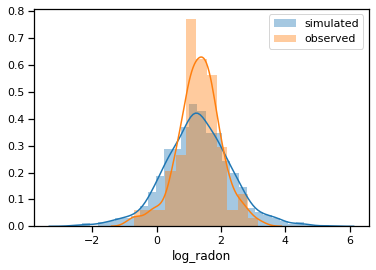

In [ ]:
# Model checking
sns.distplot(radon_samples, label='simulated')
sns.distplot(hen_radon, label='observed')
plt.legend()

In [ ]:
# Prior sensitivity
from pymc3 import Flat, HalfCauchy

with Model() as prior_sensitivity:
    μ = Flat('μ')
    σ = HalfCauchy('σ', 5)
    
    dist = Normal('dist', mu=μ, sd=σ, observed=hen_radon)
    sensitivity_samples = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 123.94


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efe0dd1d550>],
      dtype=object)

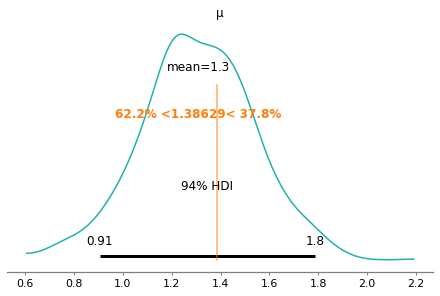

In [ ]:
plot_posterior(sensitivity_samples, var_names=['μ'], ref_val=np.log(4), color='LightSeaGreen')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efe0d1f0950>],
      dtype=object)

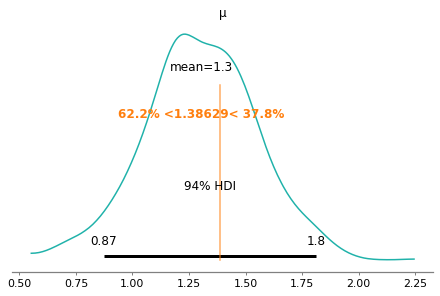

In [ ]:
plot_posterior(samples, var_names=['μ'], ref_val=np.log(4), color='LightSeaGreen')

## III. Two Groups with Continiuous Outcome

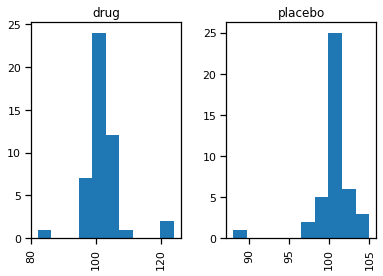

In [ ]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group');

In [ ]:
# Draw 10000 samples from a Student-T distribution
from pymc3 import StudentT

t = StudentT.dist(nu=3).random(size=10000)
n = Normal.dist(0, 1).random(size=10000)

(-10.0, 10.0)

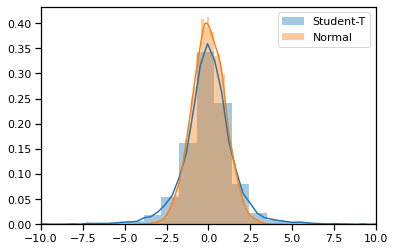

In [ ]:
sns.distplot(t, label='Student-T')
sns.distplot(n, label='Normal')
plt.legend()
plt.xlim(-10,10)

#### Prior choice

$$\mu_k \sim N(100, 10^2)$$

In [ ]:
with Model() as drug_model:
    μ_0 = Normal('μ_0', mu=100, sd=10)
    μ_1 = Normal('μ_1', mu=100, sd=10)

In [ ]:
with drug_model:
    σ_0 = Uniform('σ_0', lower=0, upper=20)
    σ_1 = Uniform('σ_1', lower=0, upper=20)

In [ ]:
from pymc3 import Exponential

with drug_model:
    ν = Exponential('ν_minus_one', 1/20.) + 1
    
    drug_like = StudentT('drug_like', nu=ν, mu=μ_1, lam=σ_1**-2, observed=drug.iq)
    placebo_link = StudentT('placebo_like', nu=ν, mu=μ_0, lam=σ_0**-2, observed=placebo.iq)

In [ ]:
# Difference of means
from pymc3 import Deterministic

with drug_model:
    diff_of_means = Deterministic('difference of means', μ_1 - μ_0)
    effect_size = Deterministic('effect size',
                               diff_of_means/np.sqrt((σ_1**2 + σ_0**2)/2))

In [ ]:
with drug_model:
    drug_trace = fit(random_seed=RANDOM_SEED).sample(1000)
    
plot_posterior(drug_trace[100:], color='#87ceeb',
               var_names=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one'])

In [ ]:
plot_posterior(drug_trace[100:], ref_val=0,
               var_names=['difference of means', 'effect size'])